## Bare pretrained Resnet backbone evaluation

In [ ]:
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import cohen_kappa_score, classification_report, accuracy_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd
import os
from torchsummary import summary
import numpy as np

BATCH = 32
label_names = ["D", "G", "A"]
device = "cuda" if torch.cuda.is_available() else "cpu"
resnet_dir = "../pretrained_backbone/ckpt_resnet18_ep50.pt"

c:\Users\Leonid\anaconda3\envs\dlearn_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_images= "../images/train"
train_labels = "../train.csv"
val_images = "../images/val"
val_labels = "../val.csv"
offsite_test_images = "../images/offsite_test"
offsite_test_labels = "../offsite_test.csv"
onsite_test_images = "../images/onsite_test"
onsite_test_labels = "../onsite_test_submission.csv"

## Datasets

In [3]:
class RetinaMultiLabelDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)
        
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row.iloc[0])
        img = Image.open(img_path).convert("RGB")
        labels = torch.tensor(row[1:].values.astype("float32"))
        if self.transform:
            img = self.transform(img)
        return img, labels

### Image transform

In [4]:
img_size=256
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

In [5]:
BATCH = 32

train = RetinaMultiLabelDataset(train_labels, train_images, transform = transform)
val = RetinaMultiLabelDataset(val_labels, val_images, transform = transform)

offsite_test = RetinaMultiLabelDataset(offsite_test_labels, offsite_test_images, transform = transform)
onsite_test = RetinaMultiLabelDataset(onsite_test_labels, onsite_test_images, transform = transform)


### Model

In [6]:
class Classifier(nn.Module):
    def __init__(self, backbone = "resnet", dir = None):
        super().__init__()

        if dir == None:
            raise FileNotFoundError
        layers = torch.load(dir)

        if backbone == "resnet":
            self.model = models.resnet18()
            self.model.fc = nn.Linear(self.model.fc.in_features, 3)
        elif backbone == "efficientnet":
            self.model = models.efficientnet_b0()
            self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, 3)
        else:
            raise ValueError("Unsupported backbone")
        self.model.load_state_dict(layers)
    
    def forward(self, X):
        return self.model(X)
        
model = Classifier(backbone="resnet", dir = resnet_dir).to(device)
summary(model, (3, 256, 256), device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

## No fine-tuning: Evaluation directly on ODIR test set

In [7]:
def eval_model(model, dataset, csv_file = None, report = False):

    loader = DataLoader(dataset, BATCH, shuffle=False)
    preds = []
    model.eval()

    for X, _ in tqdm(loader):
        output = (nn.functional.sigmoid(model(X.to(device))) > 0.5).long()
        preds.extend(output.cpu().numpy())

    preds = np.stack(preds)
    if report:
        cr = classification_report(dataset.data[label_names].to_numpy(), preds, target_names=label_names, zero_division= np.nan)
        print(cr)
    if csv_file:
        data = dataset.data.copy()
        data[label_names] = preds
        data.to_csv(csv_file, index = False)

### Onsite

In [8]:
eval_model(model, offsite_test, report= True)

100%|██████████| 7/7 [00:00<00:00,  8.41it/s]


              precision    recall  f1-score   support

           D       0.74      0.38      0.50       140
           G       0.52      0.55      0.53        49
           A       0.37      0.77      0.50        22

   micro avg       0.57      0.46      0.51       211
   macro avg       0.54      0.57      0.51       211
weighted avg       0.65      0.46      0.51       211
 samples avg       0.60      0.45      0.39       211



### Offsite

![](resnet_no_tuning.png)

In [9]:
eval_model(model, onsite_test, "resnet_submission_notune.csv")

100%|██████████| 8/8 [00:00<00:00,  8.27it/s]


## Frozen backbone, fine-tuning classifier only

In [10]:
params = model.parameters()
for layer in params:
        layer.requires_grad = False
for param in model.model.fc.parameters():
        param.requires_grad = True
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

In [11]:
checkpoints_dir = "../trained_models/"


def train_model(model, train_data, eval_data, optimizer, criterion, epochs, stepLR = None, checkpoint_name = None):
    train_loader = DataLoader(train_data,  BATCH, shuffle=True)
    val_loader = DataLoader(eval_data, BATCH, shuffle=False)
    train_size = len(train_data.data)
    eval_size = len(eval_data.data)

    train_losses = []
    val_losses = []

    f1 = []
    accuracy = []
    best_score = np.inf
    for i in range(epochs):
        model.train()
        train_loss = 0
        val_loss = 0
        val_f1 = 0
        val_accuracy = 0

        for (X, Y) in tqdm(train_loader, desc = "Training"):
            if device == "cuda":
                X = X.to(device)
                Y = Y.to(device)
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, Y)
            loss.backward()
            optimizer.step()
            train_loss += loss.item() * X.size(0)
            
        train_loss = train_loss / train_size

        model.eval()
        with torch.no_grad():
            for (X, Y) in tqdm(val_loader, desc="Validation"):
                if device == "cuda":
                    X = X.to(device)
                    Y = Y.to(device)
                output = model(X)
                loss = criterion(output, Y)
                val_loss += loss.item() * X.size(0)
                output = nn.functional.sigmoid(output)
                val_accuracy += accuracy_score((output > 0.5).cpu().long().numpy(), Y.cpu().numpy())
                val_f1 += f1_score((output > 0.5).cpu().long().numpy(), Y.cpu().numpy(),average='samples')

        val_loss = val_loss / eval_size
        val_accuracy /= np.ceil(eval_size/BATCH)
        val_f1 /= np.ceil(eval_size/BATCH)

        print(f"Epoch: {i} - Train Loss: {train_loss:2f} - Val Loss: {val_loss:2f} - Val Accuracy: {val_accuracy:2f} - Val F1 (avg. samples): {val_f1:2f}")
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        #saving model if score imporved
        if best_score > val_loss :
            print("Model improved! Saving if checkpoint_name is set.")
            best_score = val_loss
            if checkpoint_name != None:
                torch.save(model.state_dict(), checkpoints_dir + checkpoint_name)
        f1.append(val_f1)
        accuracy.append(val_accuracy)
        if stepLR != None:
                stepLR.step()
    
    x = range(0, epochs)
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 3, 1)
    plt.plot(x, train_losses, label = "Train Loss")
    plt.plot(x, val_losses, label = "Val Loss")
    plt.legend()
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.title("BCE Loss")
    plt.subplot(1, 3, 2)
    plt.plot(x, f1)
    plt.title("Val F1 (avg. samples)")
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.subplot(1, 3, 3)
    plt.plot(x, accuracy)
    plt.title("Val accuracy")
    plt.ylabel("Metric")
    plt.xlabel("Epoch")
    plt.show()

    return train_losses, val_losses, f1, accuracy

Validation: 100%|██████████| 7/7 [00:00<00:00,  8.94it/s]


Epoch: 0 - Train Loss: 1.184438 - Val Loss: 0.808582 - Val Accuracy: 0.325893 - Val F1 (avg. samples): 0.444940
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.08it/s]


Epoch: 1 - Train Loss: 0.600751 - Val Loss: 0.573938 - Val Accuracy: 0.473214 - Val F1 (avg. samples): 0.535714
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


Epoch: 2 - Train Loss: 0.503472 - Val Loss: 0.524313 - Val Accuracy: 0.477679 - Val F1 (avg. samples): 0.528274
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.80it/s]


Epoch: 3 - Train Loss: 0.469298 - Val Loss: 0.525111 - Val Accuracy: 0.508929 - Val F1 (avg. samples): 0.583333


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.50it/s]


Epoch: 4 - Train Loss: 0.464735 - Val Loss: 0.525258 - Val Accuracy: 0.500000 - Val F1 (avg. samples): 0.571429


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.10it/s]


Epoch: 5 - Train Loss: 0.464797 - Val Loss: 0.512488 - Val Accuracy: 0.504464 - Val F1 (avg. samples): 0.561012
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.54it/s]


Epoch: 6 - Train Loss: 0.458098 - Val Loss: 0.500666 - Val Accuracy: 0.500000 - Val F1 (avg. samples): 0.589286
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.02it/s]


Epoch: 7 - Train Loss: 0.453936 - Val Loss: 0.509029 - Val Accuracy: 0.500000 - Val F1 (avg. samples): 0.556548


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.71it/s]


Epoch: 8 - Train Loss: 0.448969 - Val Loss: 0.510183 - Val Accuracy: 0.526786 - Val F1 (avg. samples): 0.595238


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.03it/s]


Epoch: 9 - Train Loss: 0.441355 - Val Loss: 0.491928 - Val Accuracy: 0.500000 - Val F1 (avg. samples): 0.574405
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.01it/s]


Epoch: 10 - Train Loss: 0.445596 - Val Loss: 0.482970 - Val Accuracy: 0.526786 - Val F1 (avg. samples): 0.610119
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.92it/s]


Epoch: 11 - Train Loss: 0.446383 - Val Loss: 0.493485 - Val Accuracy: 0.517857 - Val F1 (avg. samples): 0.616071


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.80it/s]


Epoch: 12 - Train Loss: 0.443145 - Val Loss: 0.535029 - Val Accuracy: 0.522321 - Val F1 (avg. samples): 0.608631


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.59it/s]


Epoch: 13 - Train Loss: 0.451562 - Val Loss: 0.522088 - Val Accuracy: 0.513393 - Val F1 (avg. samples): 0.599702


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.84it/s]


Epoch: 14 - Train Loss: 0.439554 - Val Loss: 0.489598 - Val Accuracy: 0.531250 - Val F1 (avg. samples): 0.623512


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.55it/s]


Epoch: 15 - Train Loss: 0.428257 - Val Loss: 0.481276 - Val Accuracy: 0.517857 - Val F1 (avg. samples): 0.595238
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.78it/s]


Epoch: 16 - Train Loss: 0.431990 - Val Loss: 0.488133 - Val Accuracy: 0.531250 - Val F1 (avg. samples): 0.620536


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.92it/s]


Epoch: 17 - Train Loss: 0.426877 - Val Loss: 0.489720 - Val Accuracy: 0.531250 - Val F1 (avg. samples): 0.605655


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.63it/s]


Epoch: 18 - Train Loss: 0.424112 - Val Loss: 0.490264 - Val Accuracy: 0.526786 - Val F1 (avg. samples): 0.625000


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.28it/s]


Epoch: 19 - Train Loss: 0.435195 - Val Loss: 0.469375 - Val Accuracy: 0.531250 - Val F1 (avg. samples): 0.629464
Model improved! Saving if checkpoint_name is set.


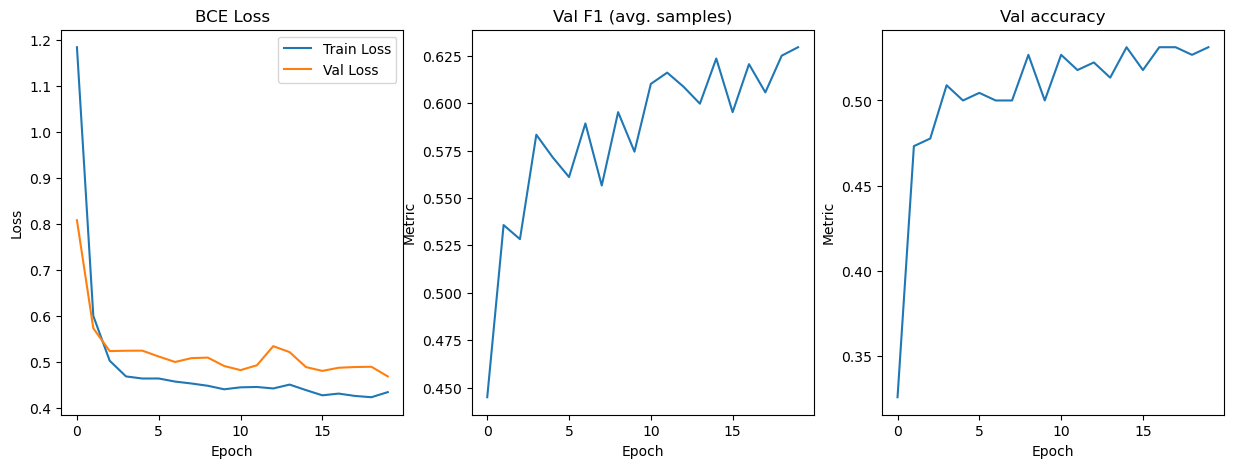

In [12]:
optimizer = torch.optim.Adam(model.model.fc.parameters(), lr = 1e-3)
criterion = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=8, gamma=0.8)
result = train_model(model, train, val, optimizer, criterion, epochs=20, stepLR=scheduler, checkpoint_name="resnet_tuned_classifer.pt")

### Offsite test

In [13]:
model = Classifier(backbone="resnet", dir = resnet_dir).to(device)
model.load_state_dict(torch.load(checkpoints_dir + "resnet_tuned_classifer.pt"))
eval_model(model, offsite_test, report= True)

100%|██████████| 7/7 [00:00<00:00,  9.25it/s]

              precision    recall  f1-score   support

           D       0.82      0.87      0.85       140
           G       0.64      0.33      0.43        49
           A       0.80      0.36      0.50        22

   micro avg       0.80      0.69      0.74       211
   macro avg       0.75      0.52      0.59       211
weighted avg       0.78      0.69      0.71       211
 samples avg       0.81      0.71      0.71       211



### Onsite test
![](resnet_classifier_tuning.png)

In [14]:
eval_model(model, onsite_test, "resnet_submission_classifier_tune.csv")

100%|██████████| 8/8 [00:00<00:00,  8.47it/s]


## Full fine-tuning

In [15]:
#model = Classifier(backbone="resnet", dir = resnet_dir).to(device)
#summary(model, (3, 256, 256))

Validation: 100%|██████████| 7/7 [00:00<00:00,  8.77it/s]


Epoch: 0 - Train Loss: 0.416410 - Val Loss: 0.438434 - Val Accuracy: 0.575893 - Val F1 (avg. samples): 0.680060
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.09it/s]


Epoch: 1 - Train Loss: 0.371618 - Val Loss: 0.417976 - Val Accuracy: 0.598214 - Val F1 (avg. samples): 0.699405
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.09it/s]


Epoch: 2 - Train Loss: 0.338749 - Val Loss: 0.402418 - Val Accuracy: 0.607143 - Val F1 (avg. samples): 0.711310
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.06it/s]


Epoch: 3 - Train Loss: 0.312823 - Val Loss: 0.395379 - Val Accuracy: 0.625000 - Val F1 (avg. samples): 0.729167
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.60it/s]


Epoch: 4 - Train Loss: 0.290599 - Val Loss: 0.388973 - Val Accuracy: 0.620536 - Val F1 (avg. samples): 0.727679
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.79it/s]


Epoch: 5 - Train Loss: 0.273405 - Val Loss: 0.380182 - Val Accuracy: 0.625000 - Val F1 (avg. samples): 0.738095
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.89it/s]


Epoch: 6 - Train Loss: 0.244861 - Val Loss: 0.384733 - Val Accuracy: 0.616071 - Val F1 (avg. samples): 0.738095


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.90it/s]


Epoch: 7 - Train Loss: 0.227339 - Val Loss: 0.379762 - Val Accuracy: 0.629464 - Val F1 (avg. samples): 0.748512
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.43it/s]


Epoch: 8 - Train Loss: 0.209921 - Val Loss: 0.381970 - Val Accuracy: 0.625000 - Val F1 (avg. samples): 0.750000


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.97it/s]


Epoch: 9 - Train Loss: 0.187274 - Val Loss: 0.378546 - Val Accuracy: 0.633929 - Val F1 (avg. samples): 0.755952
Model improved! Saving if checkpoint_name is set.


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.78it/s]


Epoch: 10 - Train Loss: 0.172299 - Val Loss: 0.379651 - Val Accuracy: 0.629464 - Val F1 (avg. samples): 0.751488


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.01it/s]


Epoch: 11 - Train Loss: 0.157892 - Val Loss: 0.384609 - Val Accuracy: 0.633929 - Val F1 (avg. samples): 0.752976


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.02it/s]


Epoch: 12 - Train Loss: 0.138584 - Val Loss: 0.388237 - Val Accuracy: 0.620536 - Val F1 (avg. samples): 0.742560


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.96it/s]


Epoch: 13 - Train Loss: 0.126347 - Val Loss: 0.386988 - Val Accuracy: 0.629464 - Val F1 (avg. samples): 0.748512


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.84it/s]


Epoch: 14 - Train Loss: 0.106912 - Val Loss: 0.391556 - Val Accuracy: 0.642857 - Val F1 (avg. samples): 0.758929


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.82it/s]


Epoch: 15 - Train Loss: 0.099747 - Val Loss: 0.392607 - Val Accuracy: 0.647321 - Val F1 (avg. samples): 0.760417


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.87it/s]


Epoch: 16 - Train Loss: 0.099591 - Val Loss: 0.391597 - Val Accuracy: 0.651786 - Val F1 (avg. samples): 0.767857


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.14it/s]


Epoch: 17 - Train Loss: 0.092333 - Val Loss: 0.392376 - Val Accuracy: 0.642857 - Val F1 (avg. samples): 0.755952


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.18it/s]


Epoch: 18 - Train Loss: 0.087291 - Val Loss: 0.396725 - Val Accuracy: 0.629464 - Val F1 (avg. samples): 0.754464


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.77it/s]


Epoch: 19 - Train Loss: 0.090012 - Val Loss: 0.392164 - Val Accuracy: 0.647321 - Val F1 (avg. samples): 0.760417


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.96it/s]


Epoch: 20 - Train Loss: 0.078122 - Val Loss: 0.395931 - Val Accuracy: 0.638393 - Val F1 (avg. samples): 0.757440


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.72it/s]


Epoch: 21 - Train Loss: 0.082246 - Val Loss: 0.395985 - Val Accuracy: 0.647321 - Val F1 (avg. samples): 0.763393


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.76it/s]


Epoch: 22 - Train Loss: 0.080758 - Val Loss: 0.396825 - Val Accuracy: 0.633929 - Val F1 (avg. samples): 0.755952


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.93it/s]


Epoch: 23 - Train Loss: 0.074490 - Val Loss: 0.398221 - Val Accuracy: 0.633929 - Val F1 (avg. samples): 0.752976


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.99it/s]


Epoch: 24 - Train Loss: 0.072289 - Val Loss: 0.401271 - Val Accuracy: 0.642857 - Val F1 (avg. samples): 0.758929


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.12it/s]


Epoch: 25 - Train Loss: 0.068484 - Val Loss: 0.404339 - Val Accuracy: 0.629464 - Val F1 (avg. samples): 0.751488


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.16it/s]


Epoch: 26 - Train Loss: 0.073204 - Val Loss: 0.407524 - Val Accuracy: 0.642857 - Val F1 (avg. samples): 0.755952


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.71it/s]


Epoch: 27 - Train Loss: 0.064074 - Val Loss: 0.406272 - Val Accuracy: 0.633929 - Val F1 (avg. samples): 0.747024


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.95it/s]


Epoch: 28 - Train Loss: 0.064054 - Val Loss: 0.400527 - Val Accuracy: 0.642857 - Val F1 (avg. samples): 0.755952


Validation: 100%|██████████| 7/7 [00:00<00:00,  8.99it/s]


Epoch: 29 - Train Loss: 0.060728 - Val Loss: 0.410457 - Val Accuracy: 0.625000 - Val F1 (avg. samples): 0.744048


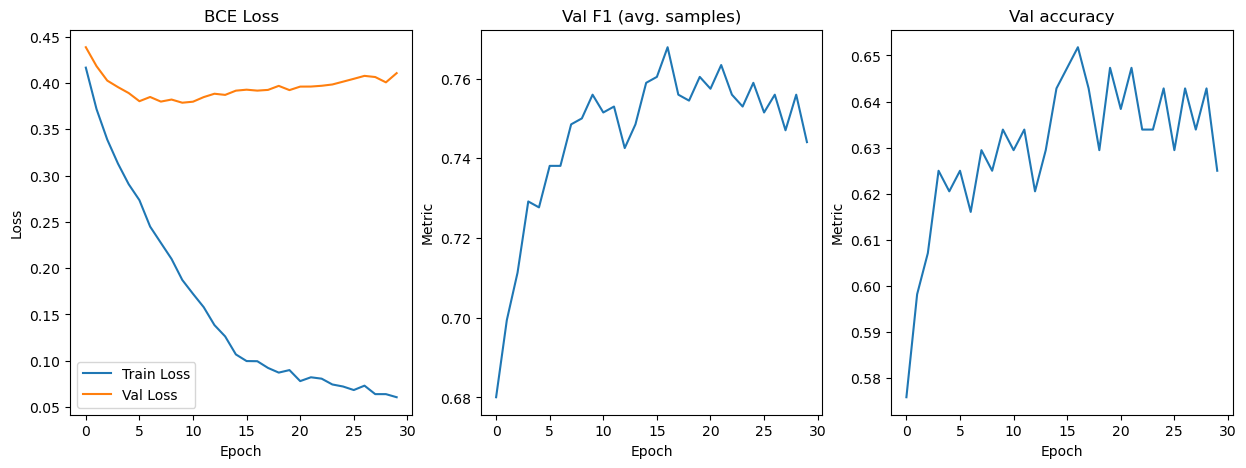

In [16]:
backbone_params = []
fc_params = []
for name, param in model.named_parameters():
    if "fc" not in name:
        backbone_params.append(param)
    else:
        fc_params.append(param)
for layer in model.parameters():
    layer.requires_grad = True

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
criterion = nn.BCEWithLogitsLoss()
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=15, gamma=0.3)
result = train_model(model, train, val, optimizer=optimizer, criterion=criterion, epochs=30, stepLR = scheduler, checkpoint_name="resnet.pt")

### Offsite

In [ ]:
eval_model(model, offsite_test, report= True)

100%|██████████| 7/7 [00:00<00:00,  8.71it/s]

              precision    recall  f1-score   support

           D       0.84      0.92      0.88       140
           G       0.91      0.59      0.72        49
           A       0.65      0.59      0.62        22

   micro avg       0.83      0.81      0.82       211
   macro avg       0.80      0.70      0.74       211
weighted avg       0.83      0.81      0.81       211
 samples avg       0.84      0.82      0.82       211



### Onsite test
![](resnet_classifier_full.png)

In [18]:
eval_model(model, onsite_test, "resnet_submission_full.csv")

100%|██████████| 8/8 [00:01<00:00,  7.96it/s]
